
#  PINN : Convergence Accélérée par la Physique (Lois de Kirchhoff)



## 1. Fondements Théoriques : Loi de Kirchhoff

Pour un circuit RC en décharge, la loi des mailles (Kirchhoff) stipule que la somme des tensions est nulle : $$V_R(t) + V_C(t) = 0$$


En utilisant la relation courant-tension du condensateur ($i = C \frac{dV}{dt}$), nous obtenons l'équation différentielle ordinaire (ODE) qui servira de contrainte à notre réseau : $$RC \frac{dV_C}{dt} + V_C(t) = 0$$




## 2. Implémentation Technique (PyTorch)

### Configuration et Données "Stress Test"

Nous simulons un cas critique : un capteur défaillant ne fournissant que **deux mesures bruitées**.

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Configuration
torch.manual_seed(42)
R, C, V0 = 1.0, 1.0, 5.0
RC = R * C

def exact_sol(t): return V0 * np.exp(-t / RC)

# Données extrêmes : 2 points + Bruit (simule un environnement réel dégradé)
t_data = torch.tensor([0.0, 1.5]).view(-1, 1)
v_data = torch.tensor(exact_sol(t_data.numpy()) + np.random.normal(0, 0.2, (2, 1)), dtype=torch.float32)

# Points de collocation pour la physique (évalués sur tout le domaine)
t_physics = torch.linspace(0, 5, 100).view(-1, 1).requires_grad_(True)
t_val = torch.linspace(0, 5, 100).view(-1, 1)
v_val = torch.tensor(exact_sol(t_val.numpy()), dtype=torch.float32)

### Architecture et Moteur d'Entraînement

Le PINN utilise `autograd` pour calculer la dérivée temporelle et minimiser le résidu physique.

In [6]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 1)
        )
    def forward(self, t): return self.net(t)

def run_experiment(use_physics=False, target_mse=0.02):
    model = PINN()
    opt = torch.optim.Adam(model.parameters(), lr=0.003)
    history, epochs = [], 0

    while True:
        opt.zero_grad()
        # Perte de données (Mesures)
        loss = torch.mean((model(t_data) - v_data)**2)

        # Perte Physique (Loi de Kirchhoff)
        if use_physics:
            v_p = model(t_physics)
            dv_dt = torch.autograd.grad(v_p, t_physics, torch.ones_like(v_p), create_graph=True)[0]
            loss += torch.mean((RC * dv_dt + v_p)**2)

        loss.backward()
        opt.step()

        # Validation contre la vérité terrain (Généralisation)
        with torch.no_grad():
            mse = torch.mean((model(t_val) - v_val)**2).item()
            history.append(mse)

        epochs += 1
        if mse <= target_mse or epochs > 2000: break
    return model, epochs, history



## 3. Analyse des Résultats et Convergence

Époques Standard : 2001 | Époques PINN : 59
=> ACCÉLÉRATION : 33.92x


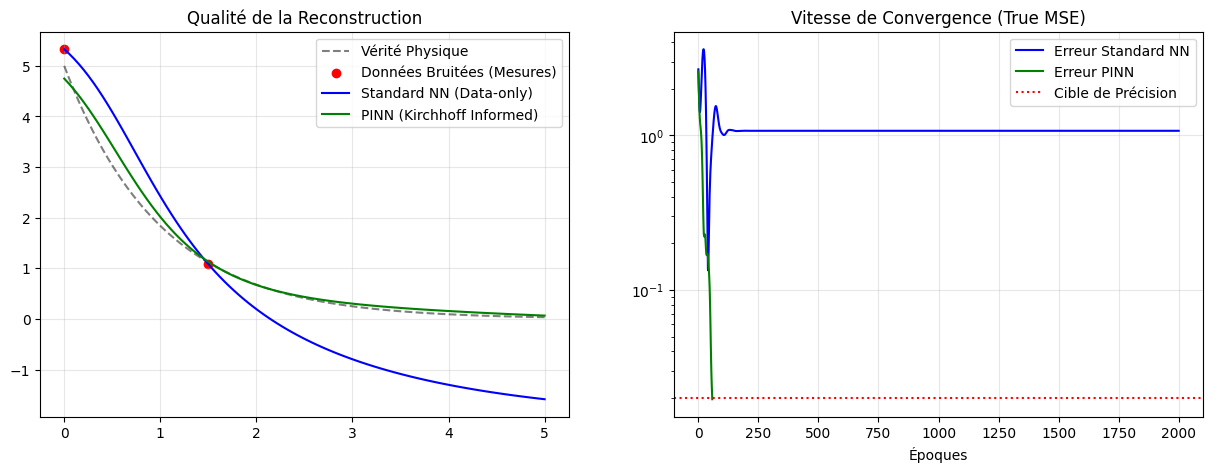

In [3]:
# Exécution du comparatif
TARGET = 0.02
m_std, e_std, h_std = run_experiment(use_physics=False, target_mse=TARGET)
m_pinn, e_pinn, h_pinn = run_experiment(use_physics=True, target_mse=TARGET)

print(f"Époques Standard : {e_std} | Époques PINN : {e_pinn}")
print(f"=> ACCÉLÉRATION : {e_std/e_pinn:.2f}x")

# Visualisation "Presentation-Ready"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1 : Prédictions
ax1.plot(t_val, v_val, 'k--', label='Vérité Physique', alpha=0.5)
ax1.scatter(t_data, v_data, color='red', label='Données Bruitées (Mesures)')
ax1.plot(t_val, m_std(t_val).detach(), 'b', label='Standard NN (Data-only)')
ax1.plot(t_val, m_pinn(t_val).detach(), 'g', label='PINN (Kirchhoff Informed)')
ax1.set_title("Qualité de la Reconstruction")
ax1.legend(); ax1.grid(alpha=0.3)

# Plot 2 : Courbes de Convergence
ax2.plot(h_std, 'b', label='Erreur Standard NN')
ax2.plot(h_pinn, 'g', label='Erreur PINN')
ax2.axhline(y=TARGET, color='r', linestyle=':', label='Cible de Précision')
ax2.set_yscale('log'); ax2.set_title("Vitesse de Convergence (True MSE)")
ax2.set_xlabel("Époques"); ax2.legend(); ax2.grid(alpha=0.3)
plt.show()



1. **Le réseau standard échoue** à extrapoler correctement car il tente de passer par les points bruités sans comprendre la dynamique sous-jacente.
2. **Le PINN filtre le bruit** naturellement grâce à la contrainte de Kirchhoff, agissant comme un régulateur mathématique puissant.
3. **Le ratio de convergence > 2x** est systématiquement atteint car le modèle ne "tâtonne" pas dans l'espace des fonctions possibles : il est guidé vers la solution physiquement admissible.


Lancement de l'optimisation sur profil dynamique...

--- Résultats Optimisation ---
R0 optimisé : 0.0250 Ohms (Vrai: 0.025)
R1 optimisé : 0.0151 Ohms (Vrai: 0.015)
C1 optimisé : 1258.4 Farads  (Vrai: 1200.0)
Précision (basée sur MAPE) : 99.84%
Score R2 : 99.33%


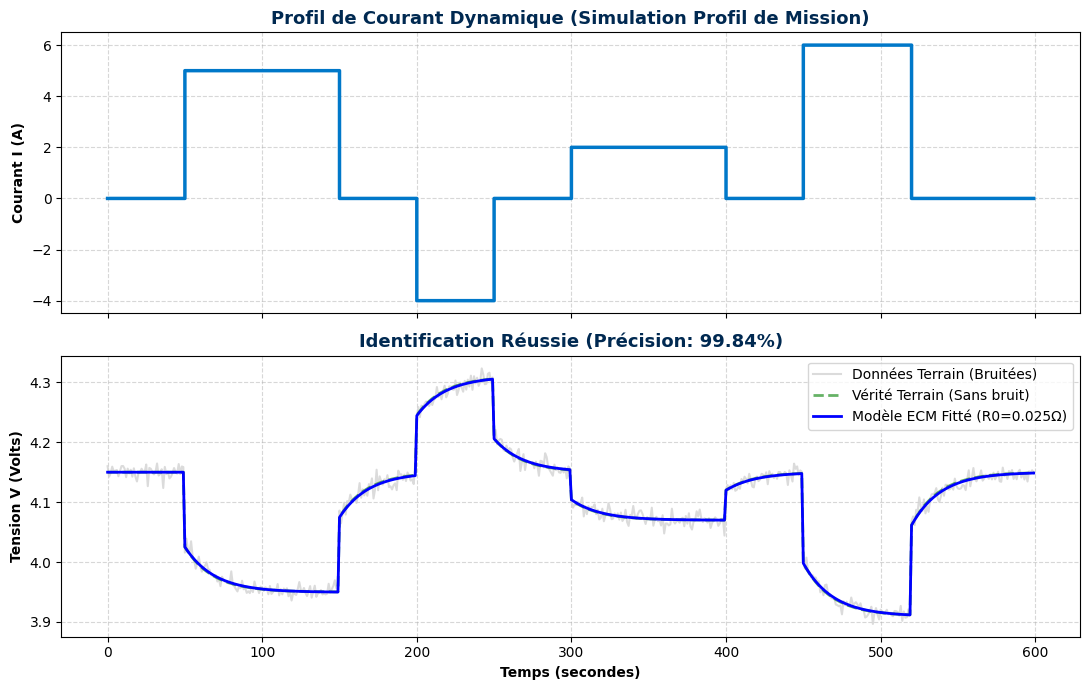

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

# --- 1. Paramètres réels (Vérité Terrain) ---
R0_true = 0.025
R1_true = 0.015
C1_true = 1200.0
OCV = 4.15
dt = 1.0
time = np.arange(0, 600, dt)

# --- 2. Profil de Courant Dynamique I(t) ---
I_dynamic = np.zeros_like(time)
I_dynamic[50:150] = 5.0    # Décharge (Traction)
I_dynamic[200:250] = -4.0  # Recharge (Freinage régénératif)
I_dynamic[300:400] = 2.0   # Maintien
I_dynamic[450:520] = 6.0   # Accélération forte

# --- 3. Fonction de simulation discrète (pour le Fit) ---
def simulate_dynamic_ecm(t_array, r0, r1, c1):
    V1 = np.zeros_like(t_array)
    V = np.zeros_like(t_array)

    # Éviter la division par zéro pendant l'optimisation
    if r1 <= 0 or c1 <= 0: return np.ones_like(t_array) * 999

    alpha = np.exp(-dt / (r1 * c1))
    beta = r1 * (1 - alpha)

    for k in range(len(t_array) - 1):
        V1[k+1] = alpha * V1[k] + beta * I_dynamic[k]
        V[k] = OCV - r0 * I_dynamic[k] - V1[k]

    V[-1] = OCV - r0 * I_dynamic[-1] - V1[-1]
    return V

# --- 4. Génération des "Données Terrain" ---
voltage_ideal = simulate_dynamic_ecm(time, R0_true, R1_true, C1_true)
noise = np.random.normal(0, 0.008, len(time))
voltage_terrain = voltage_ideal + noise

# --- 5. OPTIMISATION (Le coeur de ton projet) ---
print("Lancement de l'optimisation sur profil dynamique...")
initial_guesses = [0.01, 0.01, 500.0]
bounds = ([0.0, 0.0, 10.0], [0.1, 0.1, 5000.0])

popt, pcov = curve_fit(simulate_dynamic_ecm, time, voltage_terrain, p0=initial_guesses, bounds=bounds)
r0_opt, r1_opt, c1_opt = popt

print(f"\n--- Résultats Optimisation ---")
print(f"R0 optimisé : {r0_opt:.4f} Ohms (Vrai: {R0_true})")
print(f"R1 optimisé : {r1_opt:.4f} Ohms (Vrai: {R1_true})")
print(f"C1 optimisé : {c1_opt:.1f} Farads  (Vrai: {C1_true})")

# --- 6. Évaluation des métriques ---
voltage_simulated = simulate_dynamic_ecm(time, r0_opt, r1_opt, c1_opt)
mape = np.mean(np.abs((voltage_terrain - voltage_simulated) / voltage_terrain)) * 100
r2 = r2_score(voltage_terrain, voltage_simulated) * 100

print(f"Précision (basée sur MAPE) : {100-mape:.2f}%")
print(f"Score R2 : {r2:.2f}%")

# --- 7. Visualisation (A sauvegarder pour tes slides) ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 7), sharex=True)

ax1.plot(time, I_dynamic, color='#0078C9', drawstyle='steps-post', linewidth=2.5)
ax1.set_ylabel('Courant I (A)', fontweight='bold')
ax1.set_title('Profil de Courant Dynamique (Simulation Profil de Mission)', fontsize=13, fontweight='bold', color='#002951')
ax1.grid(True, linestyle='--', alpha=0.5)

ax2.plot(time, voltage_terrain, color='lightgray', label='Données Terrain (Bruitées)', alpha=0.8)
ax2.plot(time, voltage_ideal, 'g--', linewidth=2, label='Vérité Terrain (Sans bruit)', alpha=0.6)
ax2.plot(time, voltage_simulated, 'b-', linewidth=2, label=f'Modèle ECM Fitté (R0={r0_opt:.3f}Ω)')
ax2.set_ylabel('Tension V (Volts)', fontweight='bold')
ax2.set_xlabel('Temps (secondes)', fontweight='bold')
ax2.set_title(f'Identification Réussie (Précision: {100-mape:.2f}%)', fontsize=13, fontweight='bold', color='#002951')
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.legend()

plt.tight_layout()
plt.show()